Please **submit this Jupyter notebook through Canvas** no later than **Friday December 14, 10:59**, before the start of the lecture.

The final project is in **groups of three**, and you are expected to hand in original work. Work that is copied from another group will not be accepted.

A single, jointly written report for each group is fine. All members in a group will receive the same grade.

# Exercise 0
Write down the names + student ID of the people in your group.

----
# Project keywords
Optimization, time integration

----
# Project description
In various fields of application (e.g. physics, chemistry, biology), modeling systems as noise-driven motion in a potential landscape has been very successful. Such systems can spend most of their time in or near the bottom of a potential well, and are occasionally triggered by the noise to "hop over" to another well. How frequently such transitions occur depends on the noise amplitude. With small noise, transitions occur very infrequently ("rare events"), and the potential wells correspond to preferred states or metastable states of the system. Think of the phenomenon of protein folding, with the folded and unfolded states as metastable states.

If the noise is small and the potential smooth, transitions typically follow \textit{minimum energy paths}. An important question is what these paths look like. Answering this question by forward time integration is impractical or even impossible if the transitions are rare (in which case excessively long integrations would be needed to observe just one or a few transitions). Instead, one can try to compute the paths directly using minimization.

The following potential, with $(x_1,x_2) = \mathbf{x} \in \mathbb{R}^2$, is frequently used in this context:
$$V(x_1,x_2) = \sum_{i=1}^4 A_i \, \exp \left( a_i(x_1-\bar x_1^{(i)})^2 + b_i(x_1-\bar x_1^{(i)})(x_2-\bar x_2^{(i)} ) + c_i (x_2-\bar x_2^{(i)})^2 \right)$$
with constants 
$$\{A_i \}=(-200,-100,-170,15), \{a_i \} = (-1, -1, -6.5, 0.7), \{ b_i \}=(0, 0, 11, 0.6), $$
$$\{ c_i \} = (-10, -10, -6.5, 0.7), \{ \bar x_1^{(i)} \} = (1, 0, -0.5, -1), \{ \bar x_2^{(i)} \} = (0, 0.5, 1.5, 1).$$

This potential has three local minima, these can be found by minimization. If we have two states $\mathbf{A}$ and $\mathbf{B}$ and we want to compute the minimum energy path that connects them, we can create a chain of $N+1$ states $\{ \mathbf{x}_0, \mathbf{x}_1, ..., \mathbf{x}_N \}$ with $\mathbf{x}_0=\mathbf{A}$ and $\mathbf{x}_N=\mathbf{B}$, and define the energy of the chain as
$$E(\mathbf{x}_0, \mathbf{x}_1, ..., \mathbf{x}_N) = \sum_{j=0}^N V(\mathbf{x}_j) + \frac12 k \sum_{j=1}^N \| \mathbf{x}_j-\mathbf{x}_{j-1} \|_2^2.$$

By minimizing $E$ over the coordinates of the states $\mathbf{x}_1, ..., \mathbf{x}_{N-1}$, we can approximate the minimum energy path as the path $\mathbf{x}_0 \rightarrow \mathbf{x}_1 \rightarrow ... \rightarrow \mathbf{x}_{N}$. This method is sometimes referred to as the "elastic band" method.

----
# Project exercises

## Exercise 1
Read section 6.5 from the book by Heath.

## Exercise 2
Locate the minima of the potential $V$ by minimization. Discuss the algorithm that you use for this.

$\mathbf{x} \in \mathbb{R}^2$, is frequently used in this context:
$$V(x_1,x_2) = \sum_{i=1}^4 A_i \, \exp \left( a_i(x_1-\bar x_1^{(i)})^2 + b_i(x_1-\bar x_1^{(i)})(x_2-\bar x_2^{(i)} ) + c_i (x_2-\bar x_2^{(i)})^2 \right)$$

with constants 

$$\{A_i \}=(-200,-100,-170,15), \{a_i \} = (-1, -1, -6.5, 0.7), \{ b_i \}=(0, 0, 11, 0.6), $$
$$\{ c_i \} = (-10, -10, -6.5, 0.7), \{ \bar x_1^{(i)} \} = (1, 0, -0.5, -1), \{ \bar x_2^{(i)} \} = (0, 0.5, 1.5, 1).$$


### Locating minima

To locate the mini of function $V_{x_1, x_2}$ we have created several ways of doing so. 

1. The first is a function that is provided on https://stackoverflow.com/questions/3986345/how-to-find-the-local-minima-of-a-smooth-multidimensional-array-in-numpy-efficie. Here we create boolean array of neighborhoods where a minimum value within that neighborhood exists where the neighborhoods that contain a minimum are set to 1. This array contains all peaks, but also their surroundings, so another array is made with scipy binary erosion that is a mathematical morphology operation used for image processing. Here we find the surroundings of the peaks, which we can than substract from our earlier array, leaving us with an array filter of the indexes of the minima within the original array of $V_{x_1, x_2}$. So then applying this filter to the V array, we get the values of the local and global minima if we filter zero values out.
2. Allthough not as precise, a hillclimber or, by adding an acceptance temperature, a simulated annealing algorithm can also be used to find these minima.

### 1. Scipy functionality to find the minima

In [1]:
import numpy as np
import numpy as np
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology
from ipywidgets import interact, interactive, fixed, interact_manual
from mpl_toolkits.mplot3d import axes3d
import ipywidgets as widgets
from IPython.display import IFrame, display, HTML, Markdown
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline


def printmd(string):
    display(Markdown(string))


def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)  # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name, index=index)
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name, index=index, size=size)
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name, index=str(index or '?'))


def Vx(x1, x2, A, a, b, C, xbar1, xbar2):
    return np.sum([
        A[i] * np.exp((a[i] * (x1 - xbar1[i])**2) + (b[i] * (x1 - xbar1[i])) *
                      (x2 - xbar2[i]) + C[i] * (x2 - xbar2[i])**2)
        for i in range(len(A))
    ])

In [2]:
A = [-200, -100, -170, 15]
a = [-1, -1, -6.5, 0.7]
b = [0, 0, 11, 0.6]
c = [-10, -10, -6.5, 0.7]
xbar1 = [1, 0, -0.5, -1]
xbar2 = [0, 0.5, 1.5, 1]
xmin = -1.5
xmax = 1.5
ymin = -0.5
ymax = 2
stepRate = math.pow(10, -10)
stepSize = (abs(xmin) + abs(xmax)) * stepRate

In [3]:
def detect_local_minima(arr):
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define a connected neighborhood
    neighborhood = morphology.generate_binary_structure(len(arr.shape), 2)

    # apply the local minimum filter; all locations of minimum value
    # in their neighborhood are set to 1
    local_min = (filters.minimum_filter(arr, footprint=neighborhood) == arr)

    # local_min is a mask that contains the peaks we are
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    # we create the mask of the background
    background = (arr == 0)

    # a little technicality: we must erode the background in order to
    # successfully subtract it from local_min, otherwise a line will
    # appear along the background border (artifact of the local minimum filter)
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)

    # we obtain the final mask, containing only peaks,
    # by removing the background from the local_min mask
    detected_minima = local_min ^ eroded_background
    return np.where(detected_minima)


# fill in data within bounds
X = np.array(np.linspace(xmin, xmax, 200))
Y = np.array(np.linspace(ymin, ymax, 200))
Z = []

for x1val in X:
    temp = []
    for x2val in Y:
        V = Vx(x1val, x2val, A, a, b, c, xbar1, xbar2)
        if V > 100:
            temp.append(0)
        else:
            temp.append(V)
    Z.append(temp)
Z = np.array(Z)

# print minima
printmd(
    f"**List of minima:** {Z[detect_local_minima(Z)][Z[detect_local_minima(Z)]<0]}\n"
)

# get index of the tuple index of the minima
indexes = np.transpose(np.nonzero(Z[detect_local_minima(Z)]))

# print locations of minima
_ = [
    print(
        f"Minimum {Z[detect_local_minima(Z)][Z[detect_local_minima(Z)]<0][i]} resides on location: ({X[detect_local_minima(Z)[0][mini[0]]], Y[detect_local_minima(Z)[1][mini[0]]]})"
    ) for i, mini in enumerate(indexes)
]

forScatter = [[
    Z[detect_local_minima(Z)][Z[detect_local_minima(Z)] < 0][i],
    X[detect_local_minima(Z)[0][mini[0]]],
    Y[detect_local_minima(Z)[1][mini[0]]]
] for i, mini in enumerate(indexes)]

**List of minima:** [-146.67901464  -80.76687618 -108.16535922]


Minimum -146.6790146419298 resides on location: ((-0.5653266331658292, 1.434673366834171))
Minimum -80.76687618333995 resides on location: ((-0.05276381909547734, 0.46733668341708545))
Minimum -108.16535922119755 resides on location: ((0.6256281407035176, 0.027638190954773934))


### 2. Simulated annealing (or hillclimber when $Temp=0$)

In [4]:
def move_new(x1, x2, mut_size, max_mut=1):

    x1_lst, x2_lst, new_score = [], [], []
    x_tups = np.array([(1, 0), (1, -1), (0, -1), (-1, -1), (-1, 0), (-1, 1),
                       (0, 1), (1, 1)])

    x_tup = get_coors(x1, x2, mut_size)

    new_x = (x_tups * x_tup) + (x1, x2)
    new_score = [Vx(x[0], x[1], A, a, b, c, xbar1, xbar2) for x in new_x]
    return new_score.index(min(new_score)), new_x[new_score.index(
        min(new_score))], min(new_score)


def get_coors(x1, x2, mut_size):

    new_x1 = abs(np.random.normal(0, mut_size, 1)[0])
    new_x2 = abs(np.random.normal(0, mut_size, 1)[0])
    qiv = 1.96 * mut_size

    if -qiv < new_x1 < qiv and -qiv < new_x2 < qiv:
        return new_x1, new_x2
    return get_coors(x1, x2, mut_size)


def getScheme_data(iters, plot="No"):
    linspace = np.linspace(0, 9, iters)
    answer = []

    for x in linspace:
        answer.append(0.5 +
                      math.erf((math.sqrt(math.pi) / 2) * (x - 2)) * -0.5)
    return answer


def mp_hillclimber(n_it, n_p, climb_scheme="Hillclimb"):
    if climb_scheme == "simAn": scheme = getScheme_data(n_it)
    xcoords = np.linspace(-0.85, 0.5, n_p)
    ycoords = np.linspace(1.35, 0.0, n_p)
    coords = [(x, y) for x, y in zip(xcoords, ycoords)]
    cur_coords = coords
    cur_scores = [Vx(x[0], x[1], A, a, b, c, xbar1, xbar2) for x in coords]
    cur_score = np.mean(cur_scores)
    coors_list = {"x": [xcoords], "y": [ycoords], "z": [cur_scores]}
    for i in range(n_it):
        new_coors, new_score = [], []
        for x1, x2 in cur_coords:
            new = move_new(x1, x2, mut_size=0.05)
            new_coors.append(new[1])
            new_score.append(new[2])
        if np.mean(new_score) < cur_score:
            cur_score = np.mean(new_score)
            cur_coords = new_coors
            coors_list["x"].append(list(np.array(new_coors)[:, 0]))
            coors_list["y"].append(list(np.array(new_coors)[:, 1]))
            coors_list["z"].append(new_score)
        elif climb_scheme == "simAn":
            if scheme[i] > np.random.uniform():
                cur_score = np.mean(new_score)
                cur_coords = new_coors
                coors_list["x"].append(list(np.array(new_coors)[:, 0]))
                coors_list["y"].append(list(np.array(new_coors)[:, 1]))
                coors_list["z"].append(new_score)

    return coors_list


data = mp_hillclimber(100, 6)
printmd("**Hillclimber algorithm**")
_ = [
    print(
        f"Eventual coordinates of Hillclimber algorithm: ({round(data['x'][-1][i], 4), round(data['y'][-1][i], 4)} ended on score {round(data['z'][-1][i], 4)}"
    ) for i in range(len(data["x"][-1]))
]
printmd("\n**Simulated annealing algorithm**")
data = mp_hillclimber(100, 6, "simAn")

_ = [
    print(
        f"Eventual coordinates of simulated annealing algorithm: ({round(data['x'][-1][i], 4), round(data['y'][-1][i], 4)} ended on score {round(data['z'][-1][i], 4)}"
    ) for i in range(len(data["x"][-1]))
]

**Hillclimber algorithm**

Eventual coordinates of Hillclimber algorithm: ((-0.5567, 1.4403) ended on score -146.6902
Eventual coordinates of Hillclimber algorithm: ((-0.5629, 1.4419) ended on score -146.6735
Eventual coordinates of Hillclimber algorithm: ((-0.0512, 0.4677) ended on score -80.7671
Eventual coordinates of Hillclimber algorithm: ((-0.0512, 0.4722) ended on score -80.7462
Eventual coordinates of Hillclimber algorithm: ((0.6079, 0.0243) ended on score -108.071
Eventual coordinates of Hillclimber algorithm: ((0.6263, 0.0299) ended on score -108.1585



**Simulated annealing algorithm**

Eventual coordinates of simulated annealing algorithm: ((-0.5579, 1.4368) ended on score -146.669
Eventual coordinates of simulated annealing algorithm: ((-0.5589, 1.4327) ended on score -146.6193
Eventual coordinates of simulated annealing algorithm: ((-0.0481, 0.4617) ended on score -80.751
Eventual coordinates of simulated annealing algorithm: ((-0.0505, 0.4707) ended on score -80.756
Eventual coordinates of simulated annealing algorithm: ((0.6202, 0.0294) ended on score -108.1616
Eventual coordinates of simulated annealing algorithm: ((0.6224, 0.0274) ended on score -108.1657


## Exercise 3
Make a figure of the potential $V(\mathbf{x})$ for $(x_1,x_2) \in [-1.5, 1.5]\times [-0.5,2]$. Indicate the locations of the minima.

### Again, we present 2 ways

For this exercise we have created two ways of visualizing the function.

1. A wireframe is presented to show the overall flow of data in 3d.
2. A countour figure is given with the points as they are calculated within the simulated annealing algorithm. With the slider above, we can move through simulation time and see the dots reacting to the algorithm, moving towards the minima.


<div class="alert alert-danger">
Note: The contouring shows a strange deviation from the scatter dots with respect to the contour picture. A strange sight, but the code works properly so please excuse us for this strange behaviour.
</div>

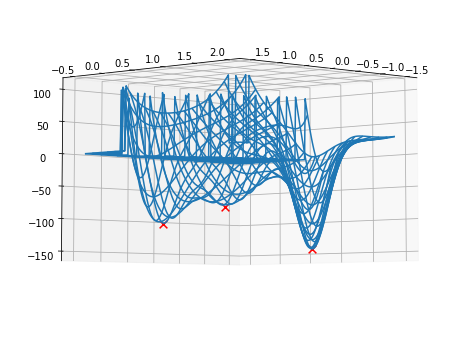

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

X3d = np.array([X for x in np.flip(X,0)])
Y3d = np.array([np.repeat(np.array([y]), len(Y)) for y in Y])
Z3d = np.flip(np.flip(np.array(Z),0),1)

# Plot a basic wireframe.
ax.plot_wireframe(X3d, Y3d, Z3d, rstride=10, cstride=10)
for i in range(len(forScatter)):
    ax.scatter(forScatter[i][1],forScatter[i][2],forScatter[i][0], c="r", s=60, marker="x")

elevation=-5 #or -15
angle=(45)
ax.view_init(elev = elevation, azim=angle)
plt.draw()

In [6]:
def showPlot(i=0):
    contours = plt.contour(X, Y, Z, 3, colors='black')
    plt.clabel(contours, inline=True, fontsize=8)

    plt.imshow(
        Z,
        extent=[np.min(X), np.max(X),
                np.min(Y), np.max(Y)],
        origin='lower',
        cmap='RdGy',
        alpha=0.7)
    plt.colorbar()
    for j in range(len(data["x"][i])):
        plt.scatter(data["x"][i][j], data["y"][i][j], c="b")
    plt.show


y = interactive(showPlot, i=(0, len(data["x"]) - 1, 1))
display(y)

interactive(children=(IntSlider(value=0, description='i', max=34), Output()), _dom_classes=('widget-interact',…

## Exercise 4
What are the free variables of the chain energy $E$  (there should be $2N-2$ in total)?

The free variables consist of the following variables of vector X:

$$x_{1_1} \rightarrow x_{2_1} \rightarrow x_{1_2} \rightarrow x_{2_2} \cdots x_{1_N-1} \rightarrow x_{2_N-1}$$

The first step to determining the gradient is to calculate the partial derivative for every variable:

$$f'(x_1) = \sum_{i=0}^N \sum_{j=1}^4 A_j* (2a_j(x_{1_i}- \hat{x}_1^{(j)})+b_j(x_{2_i}- \hat{x}_2^{(j)}))*e^{a_j(x_{1_i}- \hat{x}_1^{(j)}) + b_j(x_{1_i}- \hat{x}_1^{(j)})(x_{2_i}- \hat{x}_2^{(j)})} + \frac k2 \sum_{i=1}^N(x_{1_i} - x_{1_{i-1}})^2 $$  

$$f'(x_2) = \sum_{i=0}^N \sum_{j=1}^4 A_j* (2c_j(x_{2_i}- \hat{x}_2^{(j)})+b_j(x_{1_i}- \hat{x}_1^{(j)}))*e^{b_j(x_{1_i}- \hat{x}_1^{(j)})(x_{2_i}- \hat{x}_2^{(j)}) + c_j(x_{2_i}- \hat{x}_2^{(j)})^2} + \frac k2 \sum_{i=1}^N(x_{2_i} - x_{2_{i-1}})^2 $$ 

Now we can determine the gradient as follows:
$$\nabla E(x1,x2)=
\begin{pmatrix}  \sum_{j=1}^4 A_j*(2a_j(x_{1_1}- \hat{x}_1^{(j)})+b_j(x_{2_1}- \hat{x}_2^{(j)}))*e^{a_j(x_{1_1}- \hat{x}_1^{(j)}) + b_j(x_{1_1}- \hat{x}_1^{(j)})(x_{2_1}- \hat{x}_2^{(j)})} + \frac k2(x_{1_1} - x_{1_0})^2\\   
 \sum_{j=1}^4 A_j*(2c_j(x_{2_2}- \hat{x}_2^{(j)})+b_j(x_{1_2}- \hat{x}_1^{(j)}))*e^{b_j(x_{1_1}- \hat{x}_1^{(j)})(x_{2_1}- \hat{x}_2^{(j)}) + c_j(x_{2_1}- \hat{x}_2^{(j)})^2} +\frac k2(x_{2_1} - x_{2_0})^2\\
\vdots\\
\sum_{j=1}^4 A_j*(2a_j(x_{1_{n-1}}- \hat{x}_1^{(j)})+b_j(x_{2_{n-1}}- \hat{x}_2^{(j)}))*e^{a_j(x_{1_{n-1}}- \hat{x}_1^{(j)}) + b_j(x_{1_{n-1}}- \hat{x}_1^{(j)})(x_{2_{n-1}}- \hat{x}_2^{(j)})} + \frac k2 (x_{1_{n-1}} - x_{1_{n-2}})^2\\
\sum_{j=1}^4 A_j*(2c_j(x_{2_{n-1}}- \hat{x}_2^{(j)})+b_j(x_{1_{n-1}}- \hat{x}_1^{(j)}))*e^{b_j(x_{1_{n-1}}- \hat{x}_1^{(j)})(x_{2_{n-1}}- \hat{x}_2^{(j)}) + c_j(x_{2_{n-1}}- \hat{x}_2^{(j)})^2} + \frac k2 (x_{2_{n-1}} - x_{2_{n-2}})^2 \end{pmatrix} $$



## Exercise 5
Formulate the steepest descent method to minimize $E$ under variation of the free variables.

In [16]:
from sympy import *
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

A = [-200, -100, -170, 15]
a = [-1, -1, -6.5, 0.7]
b = [0, 0, 11, 0.6]
c = [-10, -10, -6.5, 0.7]
xbar1 = [1, 0, -0.5, -1]
xbar2 = [0, 0.5, 1.5, 1]
xmin = -1.5
xmax = 1.5
ymin = -0.5
ymax = 2
stepRate = math.pow(10, -10)
stepSize = (abs(xmin) + abs(xmax)) * stepRate

x1 = Symbol("x1")
x2 = Symbol("x2")
f = (-200 * exp((-1 * (x1 - 1)**2) +
                (0 * (x1 - 0)) * (x2 - 0) + -10 * (x2 - 0)**2)) + (-100 * exp(
                    (-1 * (x1 - 0)**2) + (0 * (x1 - 0)) * (x2 - 0.5) + -10 *
                    (x2 - 0.5)**2)) + (-170 * exp(
                        (-6.5 * (x1 - -0.5)**2) +
                        (11 * (x1 - -0.5)) * (x2 - 1.5) + -6.5 *
                        (x2 - 1.5)**2)) + (15 * exp(
                            (0.7 * (x1 - -1)**2) +
                            (11 * (x1 - -1)) * (x2 - 1) + 0.7 * (x2 - 1)**2))

fpx1 = f.diff(x1)
fpx2 = f.diff(x2)
grad = [fpx1, fpx2]

# Data
alpha = .0001
check = 0
precision = 1 / 1000000
printData = True
maxIterations = 1000


def gradient_descent(n_p, k):
    xcoords = np.linspace(-0.85, 0.5, n_p)
    ycoords = np.linspace(1.35, 0.0, n_p)
    x1Data = [xcoords]
    x2Data = [ycoords]
    VData = [[
        f.subs([(x1, xcoords[i]), (x2, ycoords[i])]).evalf()
        for i in range(len(xcoords))
    ]]

    for iterations in log_progress(range(maxIterations), every=1):
        temp_scores = []
        temp_theta = []
        temp_theta1 = []
        for i1, theta in enumerate(xcoords):
            theta1 = ycoords[i1]
            temptheta = theta - alpha * N(
                fpx1.subs(x1, theta).subs(x2, theta1)).evalf()
            temptheta1 = theta1 - alpha * N(fpx2.subs(x2, theta1)).subs(
                x1, theta).evalf()

            #If the number of iterations goes up too much, maybe theta (and/or theta1)
            #is diverging! Let's stop the loop and try to understand.
            if iterations + 1 > maxIterations:
                print(
                    "Too many iterations. Adjust alpha and make sure that the function is convex!"
                )
                printData = False
                return 1

            #If the value of theta changes less of a certain amount, our goal is met.
            if abs(temptheta - theta) < precision and abs(temptheta1 -
                                                          theta1) < precision:
                return x1Data, x2Data, VData, iterations

            #Simultaneous update
            temp_scores.append(
                f.subs([(x1, temptheta), (x2, temptheta1)]).evalf())
            temp_theta.append(temptheta)
            temp_theta1.append(temptheta1)

        xcoords = temp_theta
        ycoords = temp_theta1

        if np.mean(temp_scores) < np.mean(VData[-1]):
            x1Data.append(temp_theta)
            x2Data.append(temp_theta1)
            VData.append(temp_scores)


x1Data, x2Data, VData, iterations = gradient_descent(10, 0)
print(len(x1Data), len(x2Data), len(VData))

58 58 58


## Exercise 6
Fix the number of states on the chain (e.g. $N=20$), and pick a value for the parameter $k$ (e.g. $k=500$). Choose two different minima of $V$ to be the begin and end states of the chain ($\mathbf x_0$ and $\mathbf x_N$) and minimize $E$. As initialization, you can use chain states on a straight line from $\mathbf x_0$ to $\mathbf x_N$.


## Exercise 7
Show the path $\mathbf{x}_0 \rightarrow \mathbf{x}_1 \rightarrow ... \rightarrow \mathbf{x}_{N}$ at several stages during the minimization of $E$ (initialization, final result, some intermediate stages).

In [8]:
def showPlot(i=0):
    contours = plt.contour(X, Y, Z, 3, colors='black')
    plt.clabel(contours, inline=True, fontsize=8)

    plt.imshow(
        Z,
        extent=[np.min(X), np.max(X),
                np.min(Y), np.max(Y)],
        origin='lower',
        cmap='RdGy',
        alpha=0.7)
    plt.colorbar()
    for j in range(len(x1Data[i])):
        plt.scatter(x1Data[i][j], x2Data[i][j], c="b")
    plt.show
    
if printData:
    print("The function "+str(f)+" converges to a minimum")
    print("Number of iterations:",iterations,sep=" ")
    print("best score =",min(VData[-1]),sep=" ")

y = interactive(showPlot, i=(0, len(x1Data) - 1, 1))
display(y)

The function -100*exp(-x1**2 - 10*(x2 - 0.5)**2) - 200*exp(-10*x2**2 - (x1 - 1)**2) - 170*exp(-6.5*(x1 + 0.5)**2 + (11*x1 + 5.5)*(x2 - 1.5) - 6.5*(x2 - 1.5)**2) + 15*exp(0.7*(x1 + 1)**2 + (11*x1 + 11)*(x2 - 1) + 0.7*(x2 - 1)**2) converges to a minimum
Number of iterations: 57
best score = -202.549511799576


interactive(children=(IntSlider(value=0, description='i', max=57), Output()), _dom_classes=('widget-interact',…


## Exercise 8
Explore what happens with larger values of $N$ and different choices for $k$. How can we interpret $k$?

In [15]:
Ns = [10,20,30]
Ks = [300,500,700]
for Nx in Ns:
    for k in Ks:
        x1Data, x2Data, VData, iterations = gradient_descent(Nx, k)
        def showPlot(i=0):
            contours = plt.contour(X, Y, Z, 3, colors='black')
            plt.clabel(contours, inline=True, fontsize=8)

            plt.imshow(
                Z,
                extent=[np.min(X), np.max(X),
                        np.min(Y), np.max(Y)],
                origin='lower',
                cmap='RdGy',
                alpha=0.7)
            plt.colorbar()
            for j in range(len(x1Data[i])):
                plt.scatter(x1Data[i][j], x2Data[i][j], c="b")
            plt.show

        if printData:
            print("The function "+str(f)+" converges to a minimum")
            print("Number of iterations:",iterations,sep=" ")
            print("best score =",min(VData[-1]),sep=" ")

        y = interactive(showPlot, i=(0, len(x1Data) - 1, 1))
        display(y)

TypeError: 'int' object is not callable

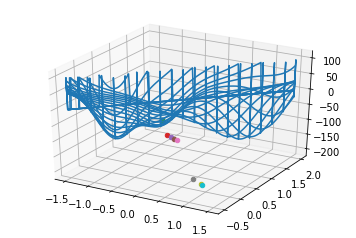

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
# %matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
for i in range(len(VData[-1])):
    ax.scatter(x1Data[-1][i], x2Data[-1][i], VData[-1][i], "b")
plt.show()